# TP2 : Pytorch and convolutional neural nets




## Warmup: 



In [212]:
import torch

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt


Basics of pytorch:
- tensors (requires_grad, detach, item): activate the computation graph
- modules: implement forward
- parameters: registered parameters in module
- nn.optimizer

- basic operations on tensors: view, expand, concat, stack, squeeze, unsqueeze, etc.

- broadcasting: 

- using a GPU: .to(device)

First step of debugging is paying attention to tensor shapes

In [213]:
# Very similar syntax to numpy.
zero_torch = torch.zeros((3, 2))

print("zero_torch is of type {:s}".format(str(type(zero_torch))))

# Torch -> Numpy: simply call the numpy() method.
zero_np = np.zeros((3, 2))
assert (zero_torch.numpy() == zero_np).all()

# Numpy -> Torch: simply call the corresponding function on the np.array.
zero_torch_float = torch.FloatTensor(zero_np)
print("\nFloat:\n", zero_torch_float)
zero_torch_int = torch.LongTensor(zero_np)
print("Int:\n", zero_torch_int)
zero_torch_bool = torch.BoolTensor(zero_np)
print("Bool:\n", zero_torch_bool)

# Reshape
print("\nView new shape...", zero_torch.view(1, 6))
# Note that print(zero_torch.reshape(1, 6)) would work too.
# The difference is in how memory is handled (view imposes contiguity).

# Algebra
a = torch.randn((3, 2))
b = torch.randn((3, 2))
print("\nAlgebraic operations are overloaded:\n", a, "\n+\n", b, "\n=\n", a + b)

# More generally, torch shares the syntax of many attributes and functions with Numpy.

zero_torch is of type <class 'torch.Tensor'>

Float:
 tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Int:
 tensor([[0, 0],
        [0, 0],
        [0, 0]])
Bool:
 tensor([[False, False],
        [False, False],
        [False, False]])

View new shape... tensor([[0., 0., 0., 0., 0., 0.]])

Algebraic operations are overloaded:
 tensor([[-0.6396, -1.2385],
        [ 0.0082, -0.5628],
        [-0.0585,  0.5287]]) 
+
 tensor([[ 0.2391, -1.0712],
        [-0.1670, -0.4725],
        [ 0.7171, -1.7277]]) 
=
 tensor([[-0.4005, -2.3098],
        [-0.1588, -1.0353],
        [ 0.6586, -1.1989]])


### Gradient management

In [214]:
# torch.Tensor is a similar yet more complicated data structure than np.array.
# It is basically a static array of number but may also contain an overlay to
# handle automatic differentiation (i.e keeping track of the gradient and which
# tensors depend on which).
# To access the static array embedded in a tensor, simply call the detach() method
print(zero_torch.detach())

# When inside a function performing automatic differentiation (basically when training
# a neural network), never use detach() otherwise meta information regarding gradients
# will be lost, effectively freezing the variable and preventing backprop for it.
# However when returning the result of training, do use detach() to save memory
# (the naked tensor data uses much less memory than the full-blown tensor with gradient
# management, and is much less prone to mistake such as bad copy and memory leak).

# We will solve theta * x = y in theta for x=1 and y=2
x = torch.ones(1)
y = 2 * torch.ones(1)

# Actually by default torch does not add the gradient management overlay
# when declaring tensors like this. To force it, add requires_grad=True.
theta = torch.randn(1, requires_grad=True)

# Optimisation routine
# (Adam is a sophisticated variant of SGD, with adaptive step).
optimizer = optim.Adam(params=[theta], lr=0.1)

# Loss function
print("Initial guess:", theta.detach())

for _ in range(100):
    # By default, torch accumulates gradients in memory.
    # To obtain the desired gradient descent beahviour,
    # just clean the cached gradients using the following line:
    optimizer.zero_grad()

    # Quadratic loss (* and ** are overloaded so that torch
    # knows how to differentiate them)
    loss = (y - theta * x) ** 2

    # Apply the chain rule to automatically compute gradients
    # for all relevant tensors.
    loss.backward()

    # Run one step of optimisation routine.
    optimizer.step()

print("Final estimate:", theta.detach())
print("The final estimate should be close to", y)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Initial guess: tensor([-1.2266])
Final estimate: tensor([1.9804])
The final estimate should be close to tensor([2.])


### nn.Module


In [215]:
# In PyTorch, every neural network is built by subclassing `nn.Module`.
# It defines:
#   - how parameters are stored,
#   - how they’re moved to GPU/CPU,
#   - the forward pass computation
# nn.Module is a way to organize layers and parameters

### Layers

linear_layer = nn.Linear(in_features=4, out_features=2)
x = torch.randn(5, 4)  # batch of 3 samples, each with 4 features
print(linear_layer(x))  # output will have shape (3, 2)


### Custom architecture


# Example: a simple two-layer network for classification
class SimpleNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()  # initialize the base nn.Module
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Defines the function computed by the network
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


# Instantiate the model
model = SimpleNet(input_dim=4, hidden_dim=16, output_dim=2)
print(model)

# Access model parameters
for name, param in model.named_parameters():
    print(name, param.shape)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

# Run a forward pass
x = torch.randn(5, 4)  # batch of 5 samples, each with 4 features
y = model(x)
print("Output:", y)

tensor([[-1.6028e-01, -1.0480e-03],
        [ 9.6509e-01,  1.3930e+00],
        [-5.3530e-01,  5.8821e-02],
        [-7.1389e-01,  1.3523e+00],
        [-3.0347e-01,  2.0622e+00]], grad_fn=<AddmmBackward0>)
SimpleNet(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)
fc1.weight torch.Size([16, 4])
fc1.bias torch.Size([16])
fc2.weight torch.Size([2, 16])
fc2.bias torch.Size([2])
Total parameters: 114
Trainable parameters: 114
Output: tensor([[-0.3170,  0.3459],
        [-0.0959,  0.3490],
        [-0.1487,  0.4562],
        [-0.3078,  0.8995],
        [ 0.0627,  0.4482]], grad_fn=<AddmmBackward0>)


# A neural net task: Recognizing the speaker

In [216]:
import torchaudio
from IPython.display import Audio

In [217]:
ds = torchaudio.datasets.LIBRISPEECH(".", url="dev-clean", download=True)
print(f"Number of data points : {len(ds)}")

# Example: access a data point
waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = ds[7]
print(transcript)
print(speaker_id)
Audio(waveform.numpy()[0], rate=sample_rate)

Number of data points : 2703
PAINTING HE TELLS US IS OF A DIFFERENT QUALITY TO MATHEMATICS AND FINISH IN ART IS ADDING MORE FACT
1272


In [218]:
# Uncomment to check the number of unique speakers in the dataset

speaker_ids = set()
for _, _, _, speaker_id, _, _ in ds:
    speaker_ids.add(speaker_id)

print(f"Dataset has {len(speaker_ids)} unique speakers in {len(ds)} points")
print(speaker_ids)
## Dataset has 40 unique speakers in 2703 points

Dataset has 40 unique speakers in 2703 points
{5895, 1673, 3081, 777, 652, 3853, 8842, 6295, 2078, 5536, 2086, 422, 3752, 6313, 7850, 7976, 174, 6319, 1462, 3000, 5694, 1988, 3576, 1993, 6345, 3536, 84, 2902, 5338, 6241, 3170, 2277, 8297, 2412, 2035, 2803, 1272, 251, 2428, 1919}


In [219]:
device = torch.device("cpu")

Let us look more in detail at some data points

Instead of working on the pure waveform, we help our model and compute a spectrogram
which we will feed as input to the network.

Transcript: PAINTING HE TELLS US IS OF A DIFFERENT QUALITY TO MATHEMATICS AND FINISH IN ART IS ADDING MORE FACT
waveform.shape=torch.Size([1, 147840])
(64, 289)


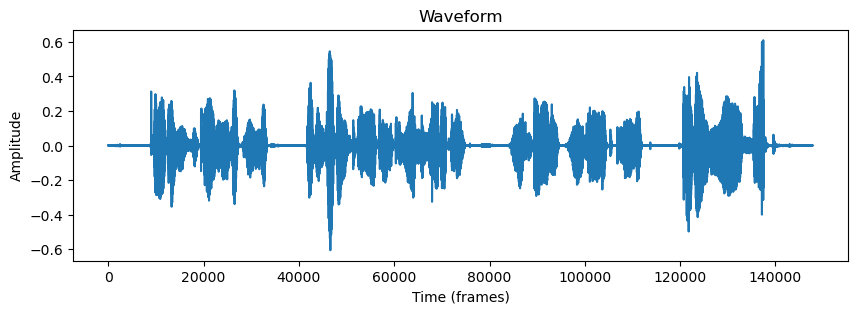

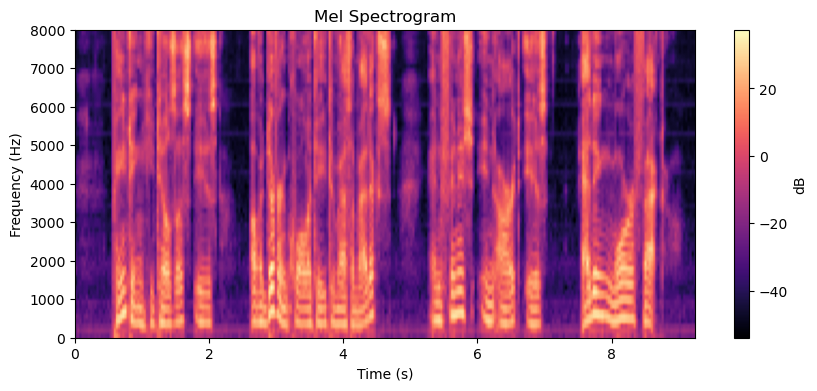

In [220]:
print(f"Transcript: {transcript}")
print(f"{waveform.shape=}")
plt.figure(figsize=(10, 3))
plt.plot(waveform.t().numpy())
plt.title("Waveform")
plt.xlabel("Time (frames)")
plt.ylabel("Amplitude")

# compute mel spectrogram and display it
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate, n_fft=1024, hop_length=512, n_mels=64
).to(device)
mel_db_transform = torchaudio.transforms.AmplitudeToDB().to(device)

waveform.to(device)

mel_spec = mel_transform(waveform)  # [1, n_mels, time]
mel_db = mel_db_transform(mel_spec)  # in dB

mel_db_np = mel_db.squeeze(0).numpy()  # [n_mels, time]


# axes for display
times = np.linspace(0, waveform.shape[1] / sample_rate, mel_db_np.shape[1])
freqs = np.linspace(0, sample_rate / 2, mel_db_np.shape[0])

plt.figure(figsize=(10, 4))
plt.imshow(
    mel_db_np,
    origin="lower",
    aspect="auto",
    cmap="magma",
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
)
print(mel_db_np.shape)
plt.colorbar(label="dB")
plt.title("Mel Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

### Idiomatic pytorch example of a Convolutional Neural Network

nn.Sequential take a tuple of layer and applies them sequential in the order provided

In [221]:
class Conv1dMel(nn.Module):
    def __init__(self, n_mels=64, n_classes=40):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(n_mels, 128, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(128, 256, 5, stride=1, padding=2),
            nn.ReLU(),  # activations have shape that depend on the input time dimension
            nn.AdaptiveAvgPool1d(
                1
            ),  # 'adaptive' means output size is fixed to 1 regardless of input size
        )
        self.fc = nn.Linear(256, n_classes)

    def forward(self, x):
        # x: batch, n_mels, time
        x = self.conv(x)  # batch, n_classes, 1
        return self.fc(x.squeeze(-1))


model = Conv1dMel().to(device)

# 1rst dimension is batch size
print(mel_db.shape)  # [1, n_mels, time]
print(model(mel_db.to(device)).shape)  # [1, n_classes]


torch.Size([1, 64, 289])
torch.Size([1, 40])


# Implemement your own Convolutional Layer
In this first section, we will reimplement the first layer ourselves, step by step. 

In [233]:
class CustomConv1in1out(nn.Module):
    # kernel_size: size of the convolution kernel
    # stride: how many steps to move the kernel at each step
    # padding: how many zeros to add at the begining and the end of the input

    def __init__(self, kernel_size, stride=1, padding=2):
        super().__init__()
        self.kernel = nn.Parameter(torch.randn(1, kernel_size) * 0.01)
        # kernel is one number per time step in window
        self.bias = nn.Parameter(torch.zeros(1))
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        # x: batch, time
        x = F.pad(x, (self.padding, self.padding))
        batch, length = x.shape
        k = self.kernel.shape[-1]
        out_length = (length - k) // self.stride + 1

        # Create output tensor
        out = torch.zeros(batch, out_length, device=x.device)
        for i in range(out_length):
            start = i * self.stride
            end = start + k
            x_slice = x[:, start:end]  # (batch, kernel_size)
            # kernel: (1, kernel_size)

            out[:, i] = (x_slice @ self.kernel.T).squeeze(1) + self.bias  # batch
        return out


custom_conv = CustomConv1in1out(5).to(device)

x = mel_db[:, 0, :]  # take first mel channel
# 1rst dimension is batch size
print(x.shape)  # [1, time]
print(custom_conv(x).shape)

torch.Size([1, 289])
torch.Size([1, 289])


In [153]:
class CustomConv1out(nn.Module):
    # kernel_size: size of the convolution kernel
    # stride: how many steps to move the kernel at each step
    # padding: how many zeros to add at the begining and the end of the input

    def __init__(self, kernel_size, in_channels, stride=1, padding=2):
        super().__init__()
        self.kernel = nn.Parameter(torch.randn(1, in_channels, kernel_size) * 0.01)
        # kernel is one vector per time step in window
        self.bias = nn.Parameter(torch.zeros(1))
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        # x: batch, in_channels, time
        x = F.pad(x, (self.padding, self.padding))
        batch, in_channels, length = x.shape
        k = self.kernel.shape[-1]
        out_length = (length - k) // self.stride + 1

        # Create output tensor
        out = torch.zeros(batch, out_length, device=x.device)
        for i in range(out_length):
            start = i * self.stride
            end = start + k
            x_slice = x[:, :, start:end]  # (batch, in_channels, kernel_size)
            # kernel: (1, in_channels, kernel_size)
            output = (x_slice * self.kernel).sum(dim=(1, 2))
            out[:, i] = output + self.bias
        return out


custom_conv = CustomConv1out(5, 64).to(device)

x = mel_db
print(x.shape)  # [1, n_mels, time]
print(custom_conv(x).shape)

torch.Size([1, 64, 289])
torch.Size([1, 289])


In [235]:
class CustomConv(nn.Module):
    # kernel_size: size of the convolution kernel
    # stride: how many steps to move the kernel at each step
    # padding: how many zeros to add at the begining and the end of the input

    def __init__(self, kernel_size, in_channels, out_channels, stride=1, padding=2):
        super().__init__()
        self.kernel = nn.Parameter(
            torch.randn(1, out_channels, in_channels, kernel_size) * 0.01
        )
        # kernel is one matrix per time step in window
        self.bias = nn.Parameter(torch.zeros(1, out_channels))
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        # x: batch, in_channels, time
        x = F.pad(x, (self.padding, self.padding))
        batch, in_ch, length = x.shape
        out_ch = self.kernel.shape[1]
        k = self.kernel.shape[-1]
        out_length = (length - k) // self.stride + 1

        # Create output tensor
        out = torch.zeros(batch, out_ch, out_length, device=x.device)
        for i in range(out_length):
            start = i * self.stride
            end = start + k
            x_slice = x[:, :, start:end].unsqueeze(1)  # (batch, 1, in_ch, kernel_size)
            # kernel: (1, out_ch, in_ch, kernel_size)
            output = (x_slice * self.kernel).sum(dim=(2, 3))
            out[:, :, i] = output + self.bias
        return out


custom_conv = CustomConv(5, 64, 128).to(device)

x = mel_db  # take first mel channel
# 1rst dimension is batch size
print(f"{x.shape=}")  # [1, n_mels, time]
print(f"Output shape {custom_conv(x).shape}")

x.shape=torch.Size([1, 64, 289])
Output shape torch.Size([1, 128, 289])


### Vectorizing
The for loop breaks parallelization possibilities. Instead, we reformulate 
the computations as tensor operations with an extra dimension. 

In [183]:
class CustomConvVectorized(nn.Module):
    # kernel_size: size of the convolution kernel
    # stride: how many steps to move the kernel at each step
    # padding: how many zeros to add at the begining and the end of the input

    def __init__(self, kernel_size, in_channels, out_channels, stride=1, padding=2):
        super().__init__()
        self.kernel = nn.Parameter(
            torch.randn(1, out_channels, in_channels, kernel_size) * 0.01
        )
        # kernel is one matrix per time step in window
        self.bias = nn.Parameter(torch.zeros(1, out_channels, 1))
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        # x: batch, in_channels, time
        x = F.pad(x, (self.padding, self.padding))
        b, in_ch, length = x.shape
        _, out_ch, _, k = self.kernel.shape
        k = self.kernel.shape[-1]

        out_length = (length - k) // self.stride + 1
        stride = self.stride

        idx = torch.arange(k, device=x.device) + torch.arange(
            0, out_length * stride, stride, device=x.device
        ).unsqueeze(1)
        # idx[i, j] = start position of window i + offset j

        # Gather all windows at once: x[:, :, idx] -> (batch, in_ch, out_length, k)
        x_slices = x[:, :, idx]  # broadcasting gather

        # Reshape kernel to (1, out_ch, in_ch, 1, k)
        kernel = self.kernel.view(1, out_ch, in_ch, 1, k)
        x_slices = x_slices.unsqueeze(1)  # (b, 1, in_ch, out_length, k)

        # kernel * x_slices: (b, out_ch, in_ch, out_length, k)

        # Elementwise multiply and sum over in_ch and k
        out = (x_slices * kernel).sum(
            dim=(2, 4)
        ) + self.bias  # (batch, out_ch, out_length)

        return out


# Check that our implementations give the same result

custom_conv_layer = CustomConv(5, 64, 128).to(device)
custom_conv_vectorized = CustomConvVectorized(5, 64, 128).to(device)
model_pytorch = nn.Conv1d(64, 128, 5, stride=1, padding=2).to(device)

# Safe way to copy the weights from model to model_vec, without affecting the flow
# of gradients in the computation graph
with torch.no_grad():
    custom_conv_vectorized.kernel.data.copy_(custom_conv_layer.kernel.data)
    custom_conv_vectorized.bias.data.copy_(custom_conv_layer.bias.data.unsqueeze(-1))

    model_pytorch.weight.copy_(custom_conv_layer.kernel.squeeze(0))
    model_pytorch.bias.copy_(custom_conv_layer.bias.squeeze(0))

x = mel_db.to(device)  # take first mel channel
# 1rst dimension is batch size
print(x.shape)  # [1, n_mels, time]
print(custom_conv_vectorized(x).shape)
print(model_pytorch(x).shape)

print(custom_conv_layer(x))
print(custom_conv_vectorized(x))
print(model_pytorch(x))


torch.Size([1, 64, 289])
torch.Size([1, 128, 289])
torch.Size([1, 128, 289])
tensor([[[ 3.6840,  3.8930,  0.8542,  ...,  4.2670,  1.7722,  1.8103],
         [-5.7530, -7.1418, -6.3500,  ..., -6.9488, -4.2568, -0.2663],
         [-1.4502, -4.2655, -3.1671,  ..., -3.8708,  1.7207,  0.7130],
         ...,
         [ 8.3077,  2.7691,  1.9681,  ...,  5.1602,  4.2353, -4.3973],
         [ 1.6623,  1.9664, -3.2362,  ..., -2.0088, -9.7084, -9.3973],
         [-4.2877,  2.4526,  7.8568,  ...,  7.8751, 14.1636, 14.7931]]],
       grad_fn=<CopySlices>)
tensor([[[ 3.6840,  3.8930,  0.8542,  ...,  4.2670,  1.7722,  1.8103],
         [-5.7530, -7.1418, -6.3500,  ..., -6.9488, -4.2568, -0.2663],
         [-1.4502, -4.2655, -3.1671,  ..., -3.8708,  1.7207,  0.7130],
         ...,
         [ 8.3077,  2.7691,  1.9681,  ...,  5.1602,  4.2352, -4.3973],
         [ 1.6623,  1.9664, -3.2362,  ..., -2.0088, -9.7084, -9.3973],
         [-4.2877,  2.4526,  7.8568,  ...,  7.8751, 14.1636, 14.7931]]],
       gra

In [145]:
%timeit model(x)
%timeit model_vec(x)
%timeit model_pytorch(x)


32.6 ms ± 2.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.6 ms ± 142 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
122 μs ± 2.5 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


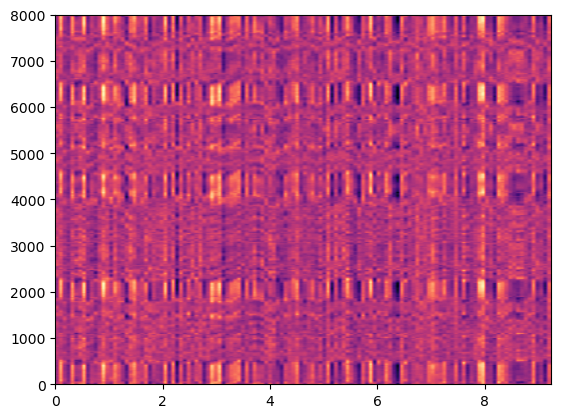

In [163]:
output = model_pytorch(x).squeeze(0).detach().numpy()

plt.imshow(
    output.T,
    origin="lower",
    aspect="auto",
    cmap="magma",
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
)
plt.show()

# Implement the pooling layers

In [169]:
class CustomMaxPoolNaive(nn.Module):
    def __init__(self, kernel_size, stride=1):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        # x: batch, in_channels, time
        b, in_ch, length = x.shape
        k = self.kernel_size
        out_length = (length - k) // self.stride + 1

        # Create output tensor
        out = torch.zeros(b, in_ch, out_length, device=x.device)
        for i in range(out_length):
            start = i * self.stride
            end = start + k
            x_slice = x[:, :, start:end]  # (batch, in_channels, kernel_size)
            out[:, :, i], _ = x_slice.max(dim=2)
        return out


class CustomMaxPoolVec(nn.Module):
    def __init__(self, kernel_size, stride=1):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        # x: batch, in_channels, time
        _, in_ch, length = x.shape
        k = self.kernel_size
        out_length = (length - k) // self.stride + 1

        # Build the indices of each pooling window
        idx = torch.arange(k, device=x.device)  # (K,)
        start = torch.arange(0, out_length * self.stride, self.stride, device=x.device)[
            :, None
        ]  # (L_out, 1)
        indices = start + idx  # shape (L_out, K)
        # e.g., [[0,1,2], [2,3,4], [4,5,6], ...]

        # x: (B, C, L) ->  (B, C, L_out, K)
        x_expanded = x[:, :, indices]  # x_expanded[b, c, i, k] = x[b, c, indices[i, k]]

        # Now take the max over the window dimension
        return x_expanded.max(dim=-1).values  # (B, C, L_out)


max_pool = CustomMaxPoolNaive(2, stride=1).to(device)
max_pool_vec = CustomMaxPoolNaive(2, stride=1).to(device)
max_pool_pytorch = nn.MaxPool1d(2, stride=1).to(device)

x = mel_db.to(device)
print(max_pool(x) - max_pool_pytorch(x))
print(max_pool_vec(x) - max_pool_pytorch(x))


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [173]:
%timeit max_pool(x)
%timeit max_pool_vec(x)
%timeit max_pool_pytorch(x)

19 ms ± 779 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
21.2 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
76.8 μs ± 3.37 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Train a network


In [201]:
model = Conv1dMel().to(device)

### Build the dataset loader
Create batches to feed the network.

In [188]:
# build mapping from speaker id to class index (use existing speaker_list if available)
spk2idx = {spk: i for i, spk in enumerate(speaker_ids)}


def get_batches(indices, batch_size):
    return [indices[i : i + batch_size] for i in range(0, len(indices), batch_size)]


# Padding: since different input sequences have different lenghths, we need to pad them
# add a default value at the start or the end) to the same length in a batch
def fetch_batch(batch_idxs, ds, device=device):
    waves = []
    targets = []
    for idx in batch_idxs:
        waveform, _, _, speaker_id, _, _ = ds[idx]
        waves.append(waveform)  # waveform shape: [1, time]
        targets.append(spk2idx[speaker_id])

    # pad to the longest waveform in the batch
    max_len = max(w.shape[1] for w in waves)
    dtype = waves[0].dtype
    batch_wave = torch.zeros(len(waves), 1, max_len, dtype=dtype, device=device)
    for i, w in enumerate(waves):
        batch_wave[i, :, : w.shape[1]] = w

    return batch_wave, torch.tensor(targets, dtype=torch.long, device=device)

In [189]:
# Evaluation function on test set
def evaluate(model, ds, test_indices, device, batch_size=8):
    model.eval()
    correct = 0
    with torch.no_grad():
        eval_batches = get_batches(test_indices, batch_size)
        for batch_idxs in eval_batches:
            batch_wave, targets = fetch_batch(batch_idxs, ds, device=device)

            mel = mel_transform(batch_wave)
            mel_db = mel_db_transform(mel).squeeze(1)  # batch, n_mels, time
            out = model(mel_db)
            preds = out.argmax(dim=1)
            correct += int((preds == targets).sum().item())

    accuracy = correct / len(test_indices)
    print(f"Test accuracy: {accuracy * 100:.2f}%")
    return accuracy

## Training loop

- shuffle the dataset, then separate train-test.
- traverse the data 

In [202]:
indices = np.array(range(0, len(ds)))
np.random.shuffle(indices)

N_train = int(0.8 * len(ds))
train_indices = indices[:N_train]
test_indices = indices[N_train:]

batch_size = 16
epochs = 4
lr = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
loss_history = []
test_acc = []
test_times = []
for e in range(epochs):
    train_batches = get_batches(train_indices, batch_size)
    running_loss = 0.0
    for step, batch_idxs in enumerate(train_batches):
        batch_wave, targets = fetch_batch(batch_idxs, ds, device=device)
        mel = mel_transform(batch_wave)
        mel_db = mel_db_transform(mel).squeeze(1)  # batch, n_mels, time

        # Forward pass
        out = model(mel_db)  # logits
        loss = criterion(out, targets)  # takes logits and target class indices

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loss_history.append(loss.item())

        if step % 100 == 0:
            test_times.append(step)
            avg = running_loss / 100
            print(
                f"Epoch {e + 1}/{epochs}  Step {step}/{len(train_batches)} "
                + f"AvgLoss {avg:.4f}"
            )
            test_acc.append(evaluate(model, ds, test_indices, device, batch_size))
            running_loss = 0.0

    epoch = e + 1  # update epoch variable for later cells

Epoch 1/4  Step 0/136 AvgLoss 0.1382
Test accuracy: 1.66%
Epoch 1/4  Step 100/136 AvgLoss 3.5739
Test accuracy: 47.50%
Epoch 2/4  Step 0/136 AvgLoss 0.0163
Test accuracy: 59.70%
Epoch 2/4  Step 100/136 AvgLoss 1.0866
Test accuracy: 77.26%
Epoch 3/4  Step 0/136 AvgLoss 0.0049
Test accuracy: 74.86%
Epoch 3/4  Step 100/136 AvgLoss 0.7488
Test accuracy: 83.73%
Epoch 4/4  Step 0/136 AvgLoss 0.0023
Test accuracy: 89.65%
Epoch 4/4  Step 100/136 AvgLoss 0.2608
Test accuracy: 95.19%


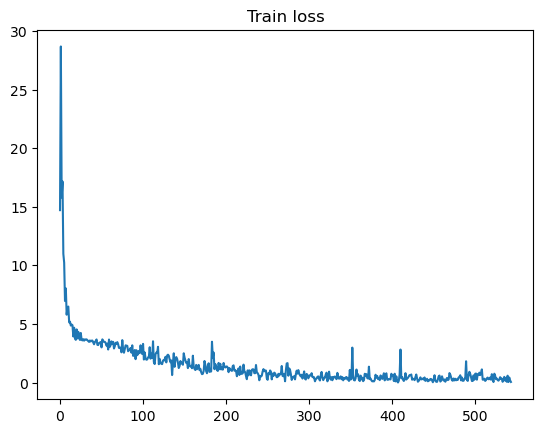

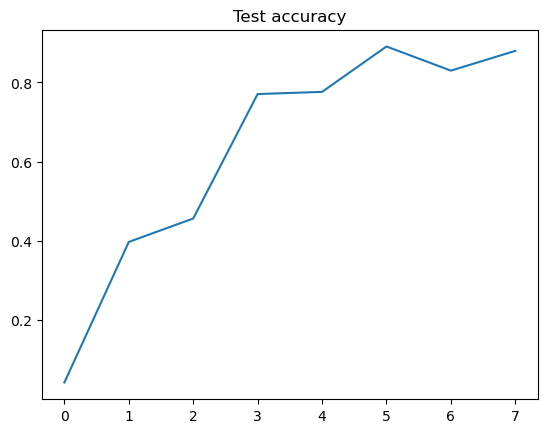

In [185]:
plt.title("Train loss")
plt.plot(loss_history)
plt.show()
plt.title("Test accuracy")
plt.plot(test_times, test_acc)
plt.show()

Found conv weights with shape (out_channels, in_channels, kernel_size): (128, 64, 5)


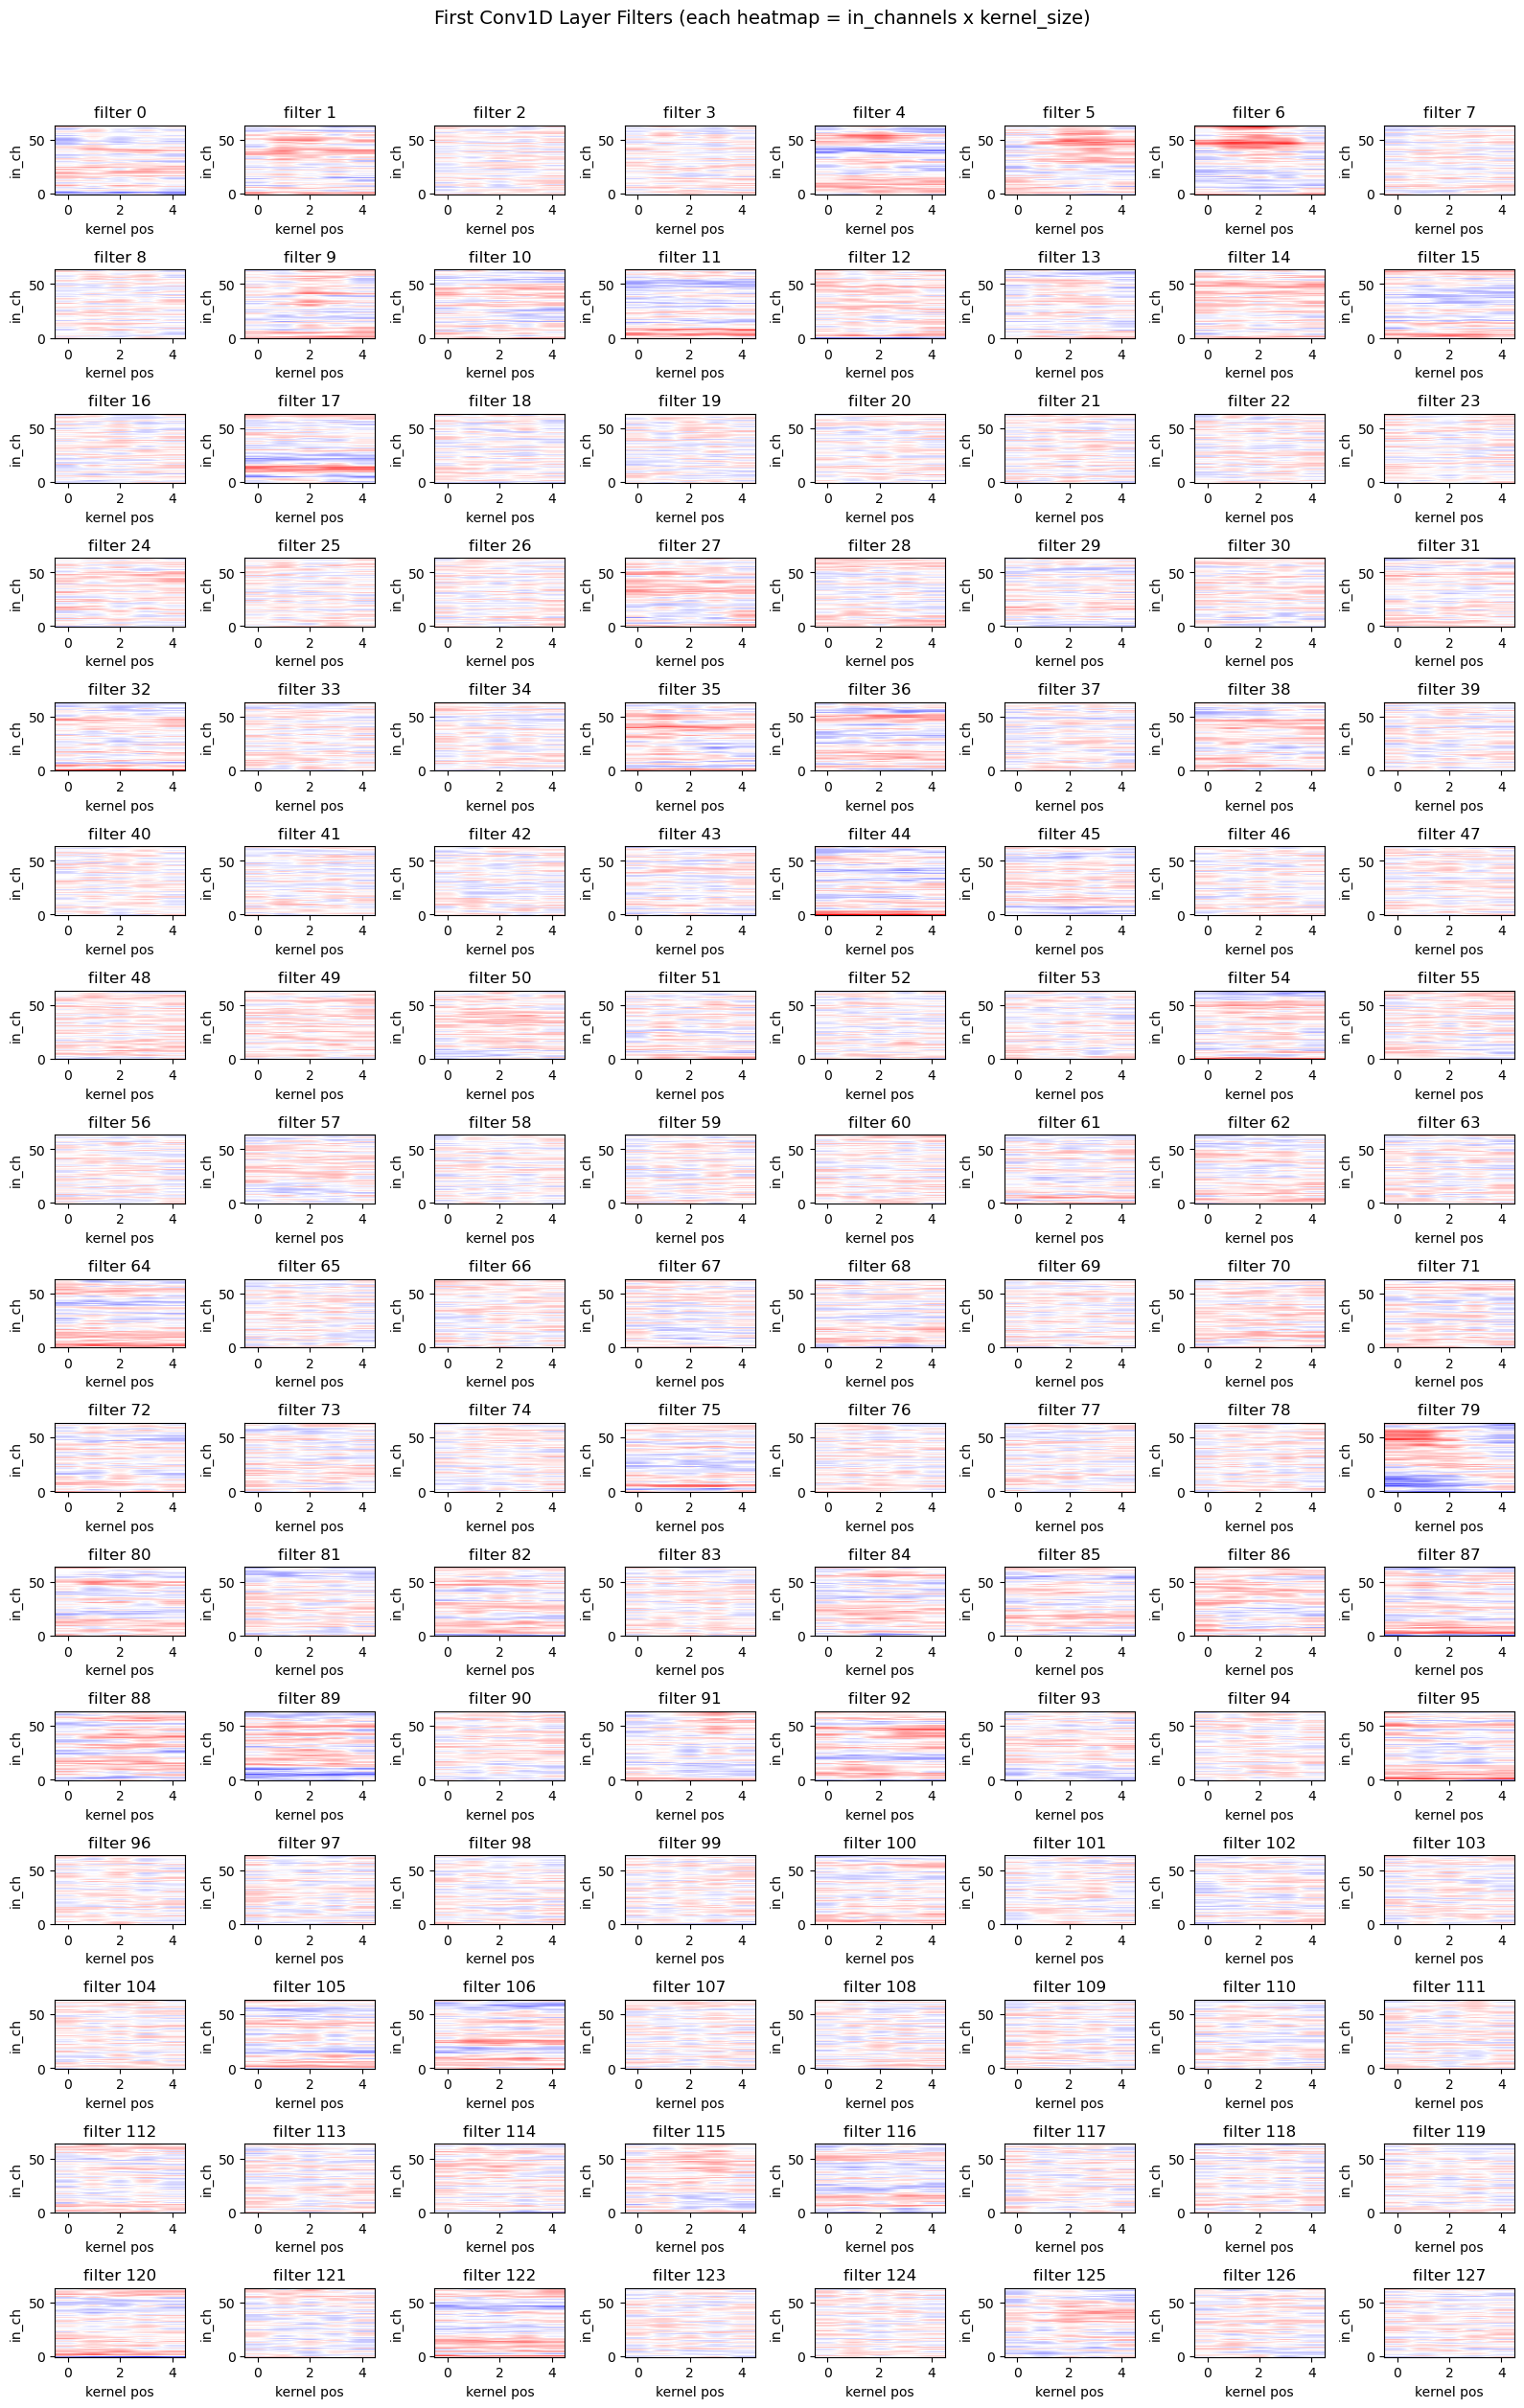

In [204]:
# Extract first conv layer weights from available candidates and plot them.
# This cell reuses imports/variables already present in the notebook (torch, np, plt, nn).

# find a conv1d weight tensor (prefer model.conv[0] if available)
conv_weight = None

conv_weight = model.conv[0].weight.detach().cpu().numpy()  # (out_ch, in_ch, kernel)

# conv_weight shape: (out_ch, in_ch, kernel_size)
out_ch, in_ch, k = conv_weight.shape
print(
    f"Found conv weights with shape (out_channels, in_channels, kernel_size): {conv_weight.shape}"
)

# plotting: show each output filter as a small heatmap of shape (in_ch, kernel_size)
ncols = min(8, out_ch)
nrows = int(np.ceil(out_ch / ncols))

maxabs = np.max(np.abs(conv_weight)) if conv_weight.size else 1.0

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 1.6), squeeze=False)
for i in range(nrows * ncols):
    r = i // ncols
    c = i % ncols
    ax = axes[r][c]
    if i < out_ch:
        im = ax.imshow(
            conv_weight[i],
            origin="lower",
            aspect="auto",
            cmap="bwr",
            vmin=-maxabs,
            vmax=maxabs,
        )
        ax.set_title(f"filter {i}")
        ax.set_xlabel("kernel pos")
        ax.set_ylabel("in_ch")
    else:
        ax.axis("off")

# shared colorbar
# fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
fig.suptitle(
    "First Conv1D Layer Filters (each heatmap = in_channels x kernel_size)", fontsize=14
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

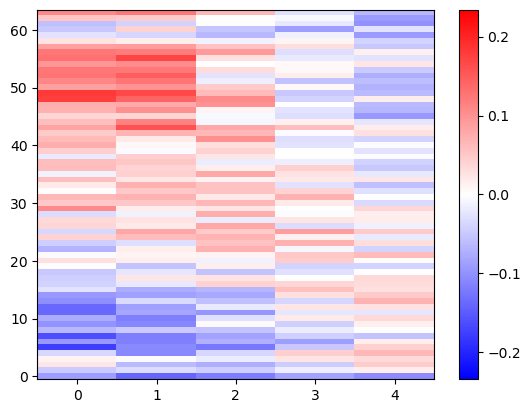

In [211]:
plt.imshow(
    conv_weight[79],
    origin="lower",
    aspect="auto",
    cmap="bwr",
    vmin=-maxabs,
    vmax=maxabs,
)
plt.colorbar()